## <p style='text-align: center;'> Analyse des emotions des Tweets 😀 😞 😡 </p> 

### <span style="color: Navy"> 1.Intorduction </span> 

La détection des émotions à partir de texte est un défi majeur en traitement du langage naturel (NLP) en raison du manque de jeux de données étiquetés et de leur complexité multi-classes. Les humains éprouvent une large gamme d'émotions qu'il est difficile de représenter avec suffisamment de données pour chaque émotion, entraînant un déséquilibre des classes. Ce jeu de données de classification des émotions a été compilé pour soutenir la recherche dans le domaine du NLP et de l'analyse des émotions. Il comprend une grande variété de textes étiquetés avec les émotions qu'ils véhiculent, allant de la joie à la colère et la tristesse. L'objectif est de construire un modèle efficace pour détecter les émotions à partir du texte en utilisant RNN.
lien de dataset: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text

### <span style="color: Navy"> 2.Importation des bibliotheques </span> 

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, precision_score, f1_score
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

### <span style="color: Navy"> 3.Nettoyage des données : </span> 

In [2]:
df=pd.read_csv('datasets\emotion_sentimen_dataset.csv')
df.head()

Unnamed: 0                                               text  Emotion
0           0  i seriously hate one subject to death but now ...     hate
1           1                 im so full of life i feel appalled  neutral
2           2  i sit here to write i start to dig out my feel...  neutral
3           3  ive been really angry with r and i feel like a...    anger
4           4  i feel suspicious if there is no one outside l...  neutral

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     839555 non-null  object
 1   Emotion  839555 non-null  object
dtypes: object(2)
memory usage: 12.8+ MB


In [5]:
df.isnull().sum()

text       0
Emotion    0
dtype: int64

In [6]:
df.duplicated().sum()

445733

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(393822, 2)

In [9]:
# Text preprocessing avec NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


### <span style="color: Navy"> 4.Normalisation des données</span>

In [4]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()] # ne garder que les mots alphabétiques
    tokens = [word.lower() for word in tokens] # mettre en minuscule
    tokens = [word for word in tokens if not word in stop_words] # suppression des mots vides
    return ' '.join(tokens)

In [10]:
df['text'] = df['text'].apply(preprocess)

In [11]:
df.head()

text  Emotion
0  seriously hate one subject death feel reluctan...     hate
1                         im full life feel appalled  neutral
2  sit write start dig feelings think afraid acce...  neutral
3  ive really angry r feel like idiot trusting fi...    anger
4  feel suspicious one outside like rapture happe...  neutral

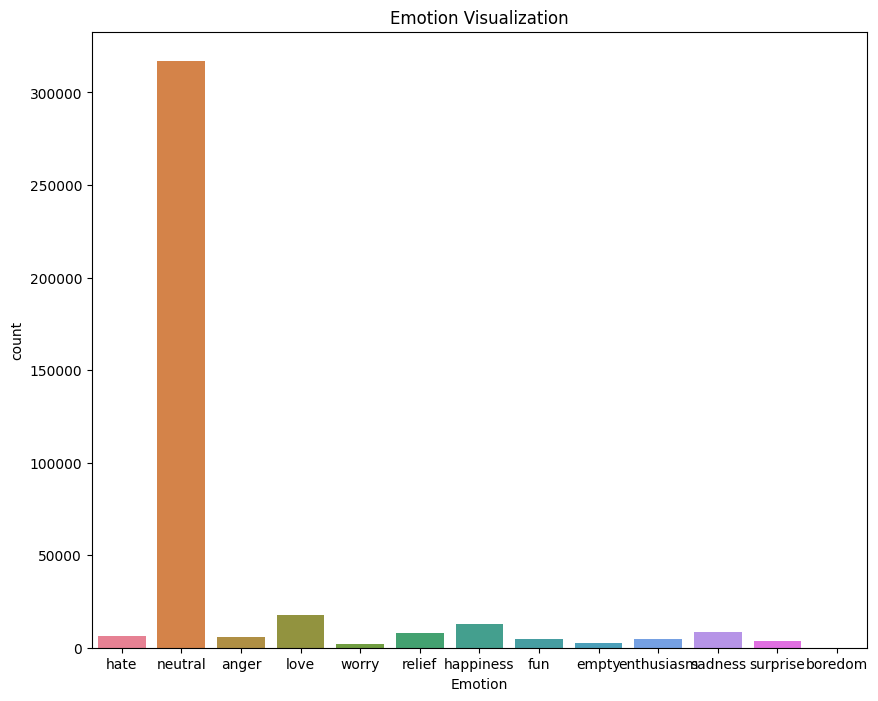

In [12]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Emotion', data=df,hue=df['Emotion'])
plt.title('Emotion Visualization')
plt.show()

### <span style="color: Navy"> 5.Encodage(Conversion des émotions en labels numériques ): </span> 

In [13]:
# Conversion des émotions en labels numériques
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['Emotion'])

In [14]:
# Récupérer les classes et les indices attribués par le LabelEncoder
label_classes = label_encoder.classes_
label_indices = {label: idx for idx, label in enumerate(label_classes)}

# Afficher les classes et leurs indices
for label, idx in label_indices.items():
    print(f"Classe : {label}, Indice : {idx}")

Classe : anger, Indice : 0
Classe : boredom, Indice : 1
Classe : empty, Indice : 2
Classe : enthusiasm, Indice : 3
Classe : fun, Indice : 4
Classe : happiness, Indice : 5
Classe : hate, Indice : 6
Classe : love, Indice : 7
Classe : neutral, Indice : 8
Classe : relief, Indice : 9
Classe : sadness, Indice : 10
Classe : surprise, Indice : 11
Classe : worry, Indice : 12


### <span style="color: Navy"> 6.Séparation des données: </span> 

In [15]:
# Séparation des variables indépendantes et de la variable cible
X = df['text']
Y = df['emotion_label']

In [16]:
# Division du dataset en ensembles d'entraînement, de validation et de test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2



### <span style="color: Navy"> 7.Tokenization et vectorisation des textes : </span>

In [17]:
# Création du vocabulaire et conversion des textes en séquences de nombres
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
# Conversion des textes en séquences de nombres et remplissage des séquences pour avoir la même longueur
maxlen = 100  # Longueur maximale des séquences
X_train_sequences = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_val_sequences = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)


### <span style="color: Navy"> 8.Création du modèle de RNN :</span>

In [19]:

vocab_size = len(tokenizer.word_index) + 1
# Création du modèle RNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))  # 13 classes d'émotion
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




### <span style="color: Navy"> 8.Compilation et entraînement du modèle :</span>

In [20]:
# Entraînement du modèle et enregistrement de l'historique
history = model.fit(X_train_sequences, y_train, batch_size=64, epochs=5, validation_data=(X_val_sequences, y_val))

Epoch 1/5
3693/3693 ━━━━━━━━━━━━━━━━━━━━ 689s 186ms/step - accuracy: 0.9151 - loss: 0.3895 - val_accuracy: 0.9972 - val_loss: 0.0185
Epoch 2/5
3693/3693 ━━━━━━━━━━━━━━━━━━━━ 649s 176ms/step - accuracy: 0.9976 - loss: 0.0116 - val_accuracy: 0.9983 - val_loss: 0.0130
Epoch 3/5
3693/3693 ━━━━━━━━━━━━━━━━━━━━ 750s 194ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9986 - val_loss: 0.0131
Epoch 4/5
3693/3693 ━━━━━━━━━━━━━━━━━━━━ 686s 186ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9988 - val_loss: 0.0114
Epoch 5/5
3693/3693 ━━━━━━━━━━━━━━━━━━━━ 713s 193ms/step - accuracy: 0.9999 - loss: 6.4747e-04 - val_accuracy: 0.9985 - val_loss: 0.0135


In [21]:
# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(X_test_sequences)
y_pred = y_pred_prob.argmax(axis=-1)

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step



### <span style="color: Navy"> 9.Évaluation du modèle :</span>

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print("accuracy :", accuracy)

accuracy : 0.9985526566368311


In [23]:
# Calcul de la précision
precision = precision_score(y_test, y_pred, average='weighted')
print("accuracy:", accuracy)


accuracy: 0.9985526566368311


In [24]:
# Calcul du score F1
f1 = f1_score(y_test, y_pred, average='weighted')
print("Score F1 (F1 score) :", f1)

Score F1 (F1 score) : 0.9985575695736713



### <span style="color: Navy"> 10.Visualisation :</span>

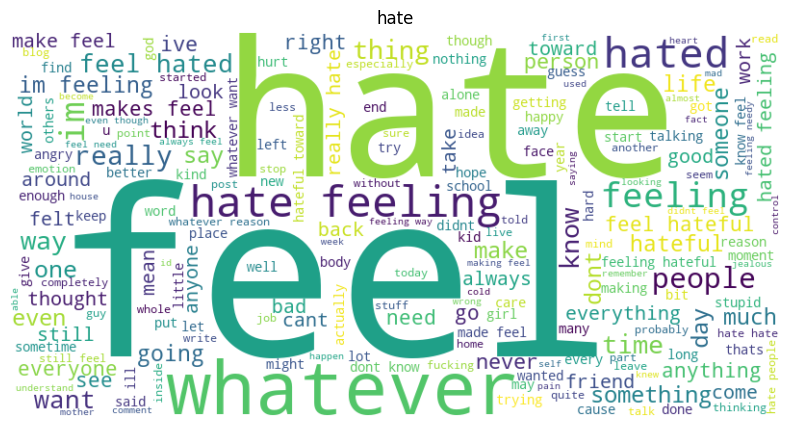

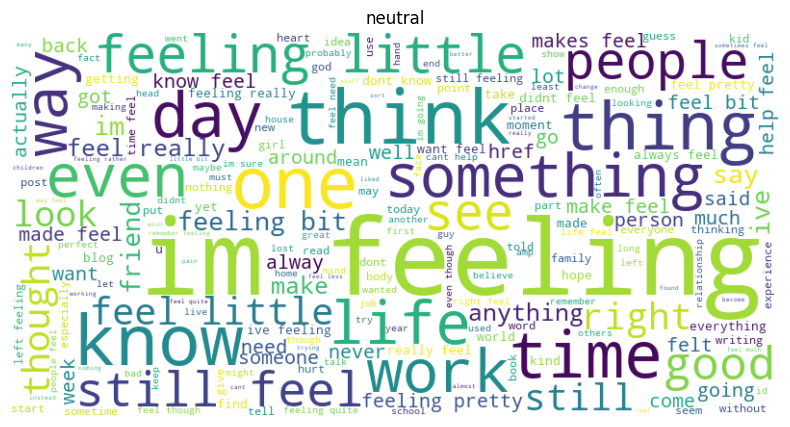

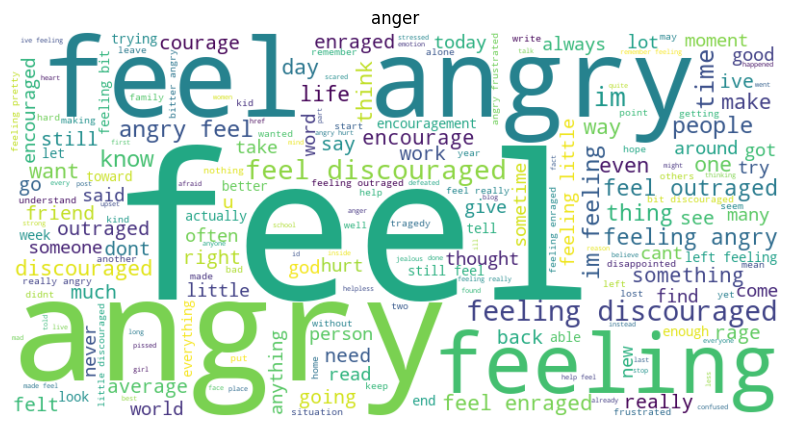

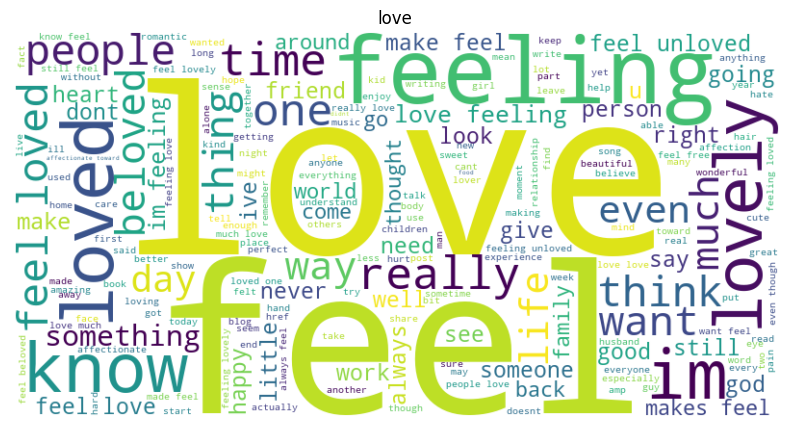

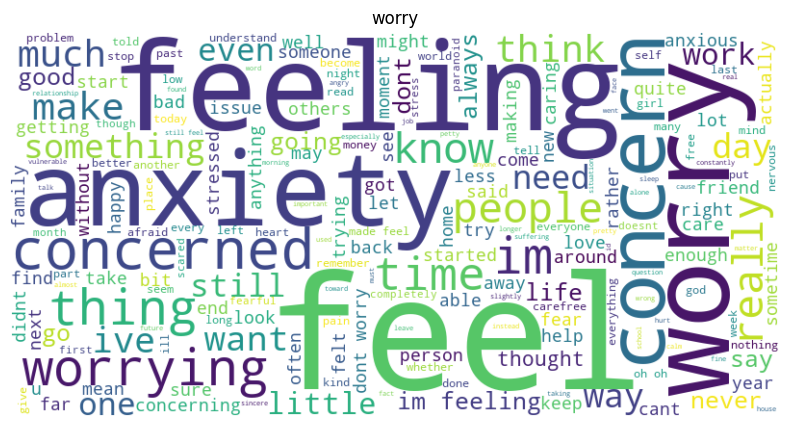

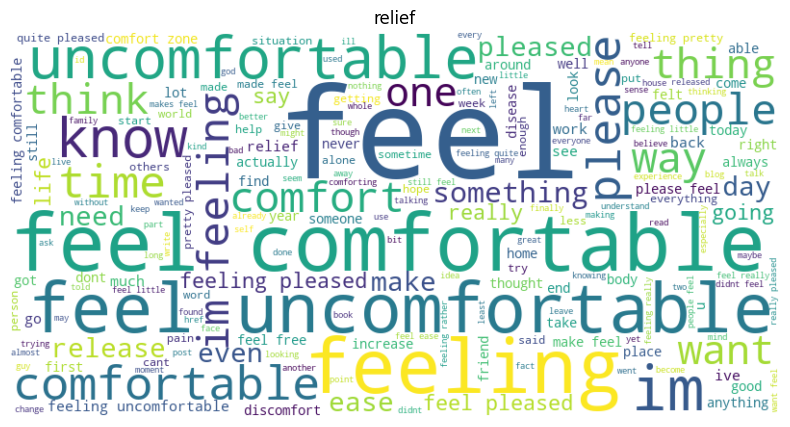

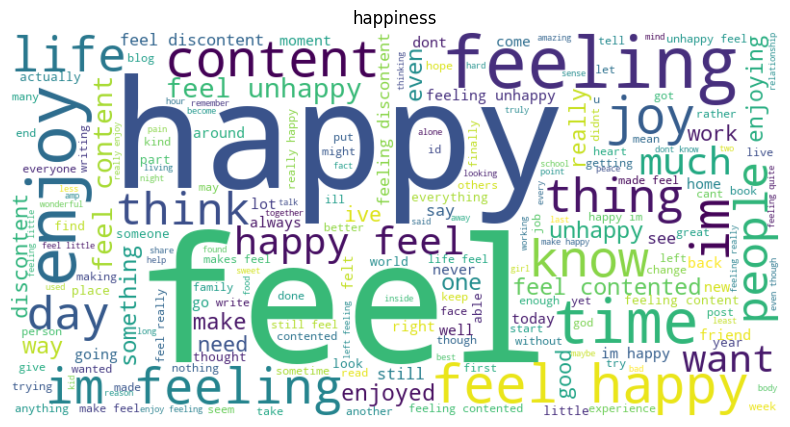

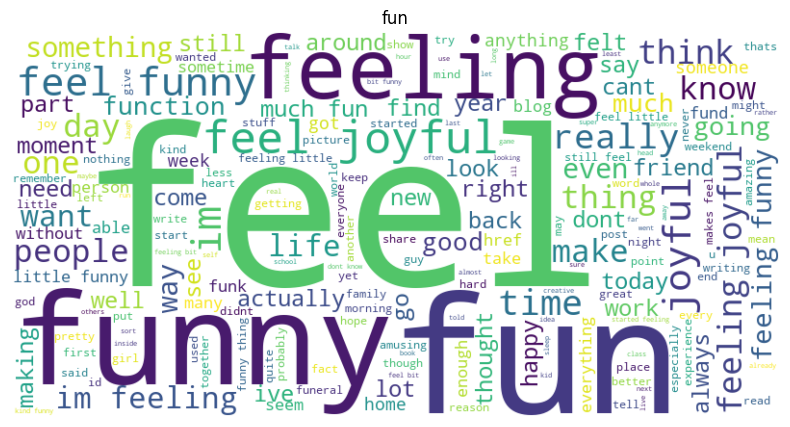

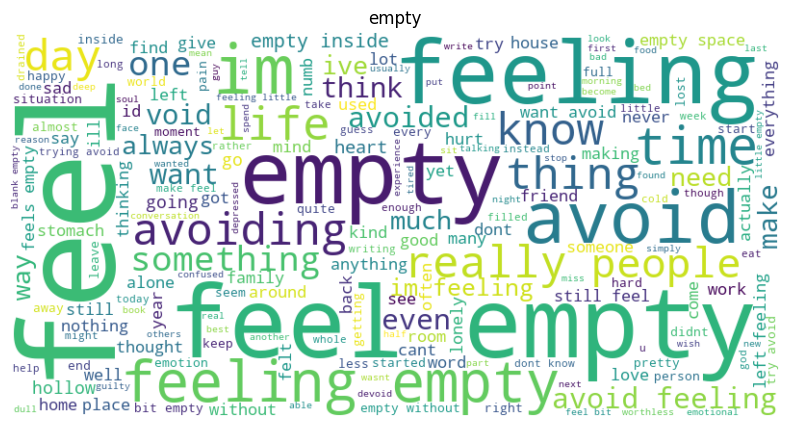

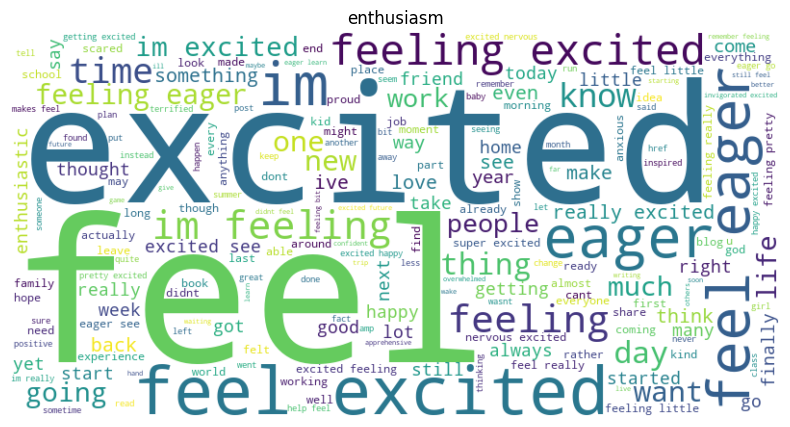

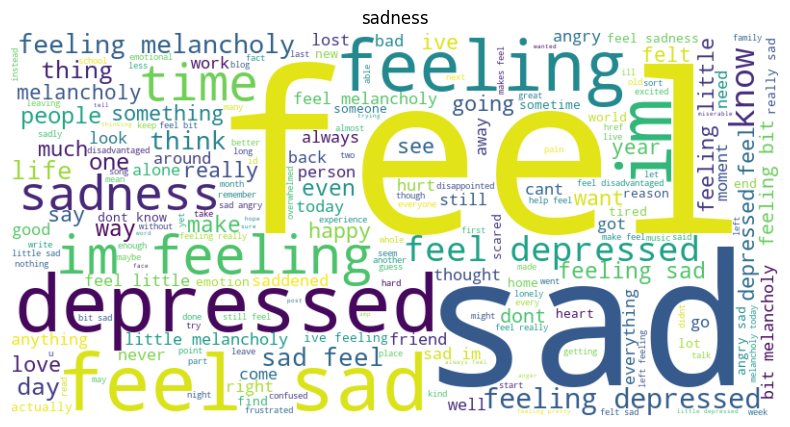

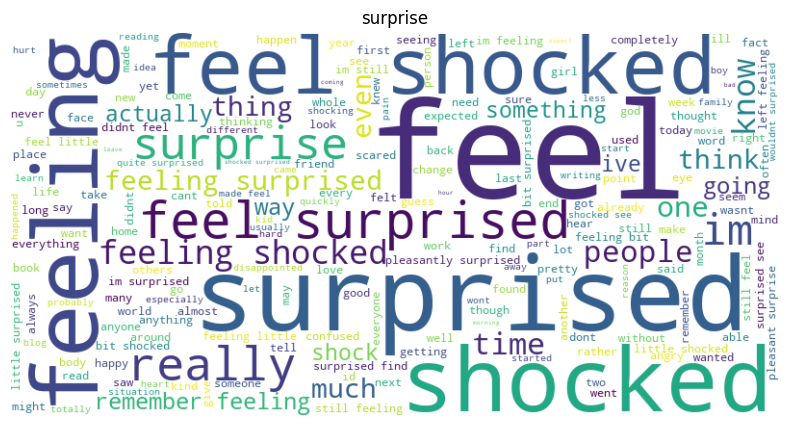

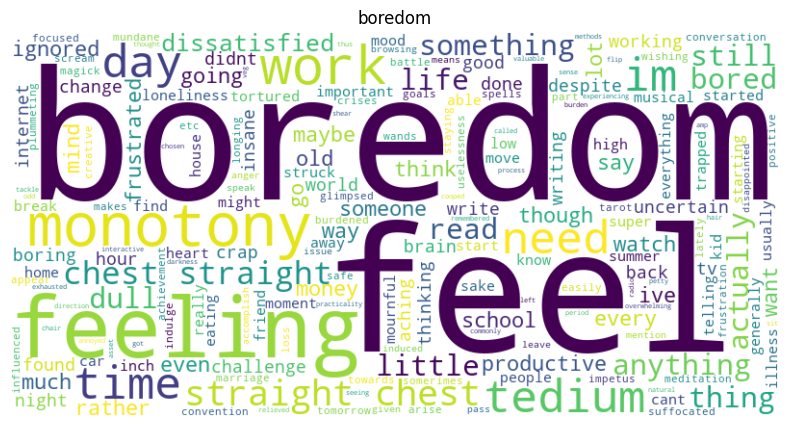

In [25]:

# Créer un dictionnaire pour stocker les textes associés à chaque émotion
emotion_texts = {}

# Filtrer les textes en fonction de l'émotion et les stocker dans le dictionnaire
for emotion in df['Emotion'].unique():
    emotion_texts[emotion] = " ".join(df[df['Emotion'] == emotion]['text'])

# Générer un nuage de mots pour chaque émotion
for emotion, text in emotion_texts.items():
    # Créer un objet WordCloud avec les paramètres appropriés
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(emotion)
    plt.axis('off')
    plt.show()


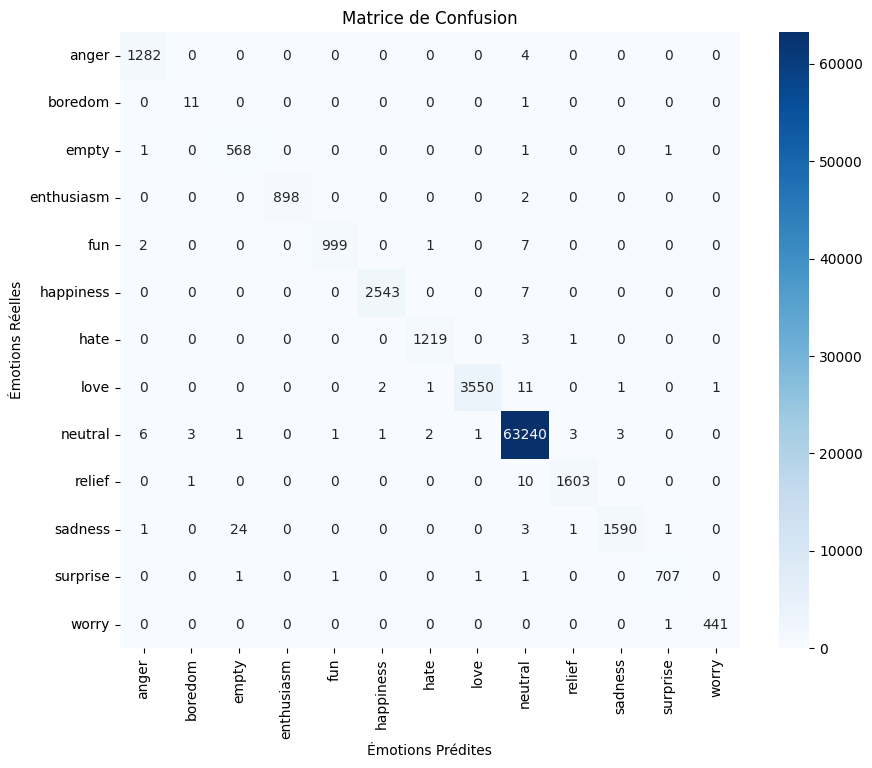

In [26]:

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Émotions Prédites')
plt.ylabel('Émotions Réelles')
plt.title('Matrice de Confusion')
plt.show()


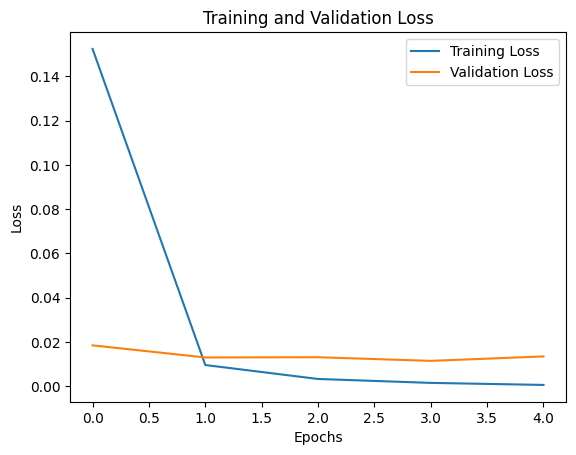

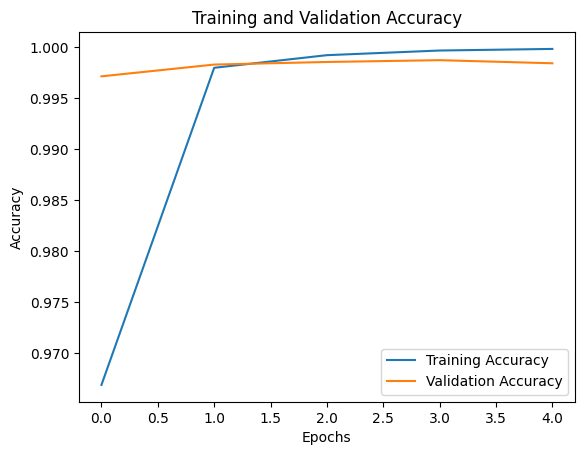

In [27]:
# Extraire les données d'historique
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### <span style="color: Navy"> 11.Prediction des nouveaux textes:</span>

In [28]:
# Fonction pour prédire l'émotion d'un texte donné
def predict_emotion(text):
    # Prétraiter le texte
    processed_text = preprocess(text)
    # Convertir le texte prétraité en séquence de nombres
    text_sequence = tokenizer.texts_to_sequences([processed_text])
    # Remplir la séquence pour avoir la même longueur que maxlen
    padded_sequence = pad_sequences(text_sequence, maxlen=maxlen)
    # Prédire l'émotion du texte
    emotion_prob = model.predict(padded_sequence)[0]
    # Obtenir l'indice de la classe ayant la probabilité la plus élevée
    predicted_class_index = emotion_prob.argmax()
    # Convertir l'indice de la classe en émotion correspondante
    predicted_emotion = label_encoder.classes_[predicted_class_index]
    return predicted_emotion

In [29]:
# Texte à prédire
text_to_predict = "After failing multiple times in my attempts to find a job, I feel depressed and discouraged."
# Prédire l'émotion du texte
predicted_emotion = predict_emotion(text_to_predict)
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted emotion: sadness


In [30]:
# Texte à prédire
text_to_predict = "I just received a promotion at work and I'm ecstatic!"
# Prédire l'émotion du texte
predicted_emotion = predict_emotion(text_to_predict)
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted emotion: neutral


In [31]:
import tensorflow as tf

# Sauvegarder le modèle
model.save("model_rnn.h5")
# Charger le modèle
model_rnn = tf.keras.models.load_model("model_rnn.h5")


In [32]:
# Convert tokenizer to JSON format
tokenizer_json = tokenizer.to_json()

# Save the JSON to a file
with open('tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_json)


In [1]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow as tf

# Charger le JSON à partir du fichier
with open('tokenizer.json') as json_file:
    tokenizer_json = json_file.read()

# Convertir le JSON en tokenizer
tokenizer = tokenizer_from_json(tokenizer_json)
# Charger le modèle
model_rnn = tf.keras.models.load_model("model_rnn.h5")


In [11]:
# Fonction pour prédire l'émotion d'un texte donné
def predict_emotion(text):
    maxlen=100
    # Prétraiter le texte
    processed_text = preprocess(text)
    # Convertir le texte prétraité en séquence de nombres
    text_sequence = tokenizer.texts_to_sequences([processed_text])
    # Remplir la séquence pour avoir la même longueur que maxlen
    padded_sequence = pad_sequences(text_sequence, maxlen=maxlen)
    # Prédire l'émotion du texte
    emotion_prob = model_rnn.predict(padded_sequence)[0]
    # Obtenir l'indice de la classe ayant la probabilité la plus élevée
    predicted_class_index = emotion_prob.argmax()
    # Convertir l'indice de la classe en émotion correspondante
    return predicted_class_index

In [12]:
# Texte à prédire
text_to_predict = "that's funny !"
# Prédire l'émotion du texte
predicted_emotion = predict_emotion(text_to_predict)
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted emotion: 4
